# Ministry of Infrastructure Planned Road Disruption
# Setting up the workspace

In [ ]:
!pip install -q statsmodels seaborn sklearn
!pip install -q ipyleaflet
!pip install -q tensorflow

In [2]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
mpl.rcParams['figure.figsize'] = 16, 10
sns.set(rc={'figure.figsize':(18.7,8.27)})

In [3]:
import statsmodels.api
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
from matplotlib import rc

from ipyleaflet import Map, Marker, MarkerCluster

import tensorflow as tf
from tensorflow import keras

import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Loading the Sensor Data

In [4]:
#This step can take a few minutes reading in the data depending on your machine specifications

#import glob

#Download and unzip data.
!wget -O rws_data.zip https://www.dropbox.com/s/j07h0istkxwgtqq/rws_data.zip?dl=1
!unzip -o  rws_data
data_path = './data'

#Read all CSV's in directory and concatenate into single dataframe
li = []
for file_path in glob.glob(data_path+'/*.csv'):
  #Sensors are organized per file. 
  # Below we load only a single file in the interest of time
  if 'PNH02_TI854R' not in file_path:
      continue
  li.append(pd.read_csv(file_path, index_col=None, header=0))
df = pd.concat(li, axis=0, ignore_index=True)
df.head()

--2023-03-03 23:02:15--  https://www.dropbox.com/s/j07h0istkxwgtqq/rws_data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/j07h0istkxwgtqq/rws_data.zip [following]
--2023-03-03 23:02:16--  https://www.dropbox.com/s/dl/j07h0istkxwgtqq/rws_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8fc7b87fc6617386cea9e1f7c0.dl.dropboxusercontent.com/cd/0/get/B3mENroU5GIfdXmDPyJH5U9tSuK72IGXOC8ejNHZrakTI4GufRrY0w2rX78iRiGOw9r9ao6eOdULQ1qjFQKa7j3sg9oM_ZYu5sCtYEh86gNMmqG5H0UGn3z2nSe4g6Y3L9rlJz6oBZhz9a2TpyyTMycCZ1509iJYEqp3dHJkaKpPZPOJbDDSFCOahvId2cVW8NE/file?dl=1# [following]
--2023-03-03 23:02:17--  https://uc8fc7b87fc6617386cea9e1f7c0.dl.dropboxusercontent.com/cd/0/get/B3mENroU5GIfdXmDPyJH5U9tSuK72IGXOC8ejNHZrakTI4GufRrY0w

,id_meetlocatie,ndw_index,start_meetperiode,eind_meetperiode,waarnemingen_intensiteit,waarnemingen_snelheid,gebruikte_minuten_intensiteit,gebruikte_minuten_snelheid,data_error_snelheid,data_error_intensiteit,...,naam_meetlocatie,voorganger,opvolger,locatie_latitude_openlr,locatie_longitude_openlr,gecalculeerde_starttijd_leveringsperiode,type_referentiewaarde,referentiewaarde_gem_intensiteit,referentiewaarde_gem_snelheid,actualiteit
0,PNH02_TI854R,F1C,2021-04-01 00:00:00,2021-04-01 01:00:00,0.0,0.0,58.0,58.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PNH02_TI854R,F2C,2021-04-01 00:00:00,2021-04-01 01:00:00,1.0,1.0,58.0,58.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PNH02_TI854R,F3C,2021-04-01 00:00:00,2021-04-01 01:00:00,0.0,0.0,58.0,58.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PNH02_TI854R,F4C,2021-04-01 00:00:00,2021-04-01 01:00:00,0.0,0.0,58.0,58.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PNH02_TI854R,F5C,2021-04-01 00:00:00,2021-04-01 01:00:00,2.0,2.0,58.0,58.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Translate Dutch column descriptors.

translate_dict = {'id_meetlocatie' : 'id_sensorlocation',
                 'ndw_index' : 'ndw_index',
                 'start_meetperiode' : 'start_measurementperiod',
                 'eind_meetperiode' : 'end_measurementperiod',
                 'waarnemingen_intensiteit' : 'n_observations_intensity',
                 'waarnemingen_snelheid' : 'n_observations_speed',
                 'gebruikte_minuten_intensiteit' : 'observation_period_intensity',
                 'gebruikte_minuten_snelheid' : 'observation_period_speed',
                 'data_error_intensiteit' : 'data_error_intensity',
                 'data_error_snelheid' : 'data_error_speed',
                 'gem_intensiteit' : 'avg_intensity',
                 'gem_snelheid' : 'avg_speed',
                 'gewogen_gem_snelheid' : 'weighted_avg_speed',
                 'rijstrook_rijbaan' : 'traffic_lane',
                 'voertuigcategorie' : 'vehicle_category',
                 'versie_meetlocatie' : 'version_sensorlocation',
                 'spreiding_intensiteit' : 'distribution_intensity',
                 'spreiding_snelheid' : 'distribution_speed',
                 'kwaliteitsindicator_snelheid' : 'quality_indicator_intensity',
                 'kwaliteitsindicator_intensiteit' : 'quality_indicator_speed',
                 'standaard_rekenmethode' : 'calculation_method',
                 'gebruikte_meetapparatuur' : 'sensor_type',
                 'naam_meetlocatie_mst' : 'location_name_mst',
                 'totaal_aantal_rijstroken' : 'number_of_traffic_lanes',
                 'rijrichting' : 'direction',
                 'nauwkeurigheid' : 'accuracy',
                 'meetperiode' : 'measurement_period',
                 'start_locatie_latitude' : 'start_location_latitude',
                 'start_locatie_longitude' : 'start_location_longitude',
                 'eind_locatie_latitude' : 'end_location_latitude',
                 'eind_locatie_longitude' : 'end_location_longitude',
                 'lengte_van_het_traject' : 'trajectory_length',
                 'specifieke_baan' : 'lane_type',
                 'naam_meetlocatie' : 'location_name',
                 'voorganger' : 'preceding',
                 'opvolger' : 'successor',
                 'locatie_latitude_openlr' : 'location_latitude_openlr',
                 'locatie_longitude_openlr' : 'location_longitude_openlr',
                 'gecalculeerde_starttijd_leveringsperiode' : 'calculated_starttime_delivery_period',
                 'type_referentiewaarde' : 'type_reference_value',
                 'referentiewaarde_gem_intensiteit' : 'referencevalue_avg_intensity',
                 'referentiewaarde_gem_snelheid' : 'referencevalue_avg_speed',
                  'actualiteit' : 'actuality'
                 }
df = df.rename(columns=translate_dict)

#Parse datetime values
df = df.assign(start_measurementperiod = pd.to_datetime(df.start_measurementperiod),
               end_measurementperiod = pd.to_datetime(df.end_measurementperiod))

In [6]:
#Take data for single sensor and sum up all number of vehicles for all traffic lanes for each vehicle category.
# category 'anyVehicle' counts all vehicles regardless of length

sensor_df = df[df.id_sensorlocation == 'PNH02_TI854R'].set_index(['start_measurementperiod','traffic_lane','vehicle_category'])
by_category = sensor_df.groupby(['start_measurementperiod','vehicle_category'])['avg_intensity'].sum()

In [7]:
by_category.reset_index()

,start_measurementperiod,vehicle_category,avg_intensity
0,2021-04-01 00:00:00,anyVehicle,94.0
1,2021-04-01 00:00:00,greaterThan 1.85 and lessThanOrEqualTo 2.40,0.0
2,2021-04-01 00:00:00,greaterThan 11.50 and lessThanOrEqualTo 12.20,2.0
3,2021-04-01 00:00:00,greaterThan 12.20,48.0
4,2021-04-01 00:00:00,greaterThan 2.40 and lessThanOrEqualTo 5.60,35.0
...,...,...,...
8923,2021-06-01 23:00:00,greaterThan 1.85 and lessThanOrEqualTo 2.40,0.0
8924,2021-06-01 23:00:00,greaterThan 11.50 and lessThanOrEqualTo 12.20,0.0
8925,2021-06-01 23:00:00,greaterThan 12.20,0.0
8926,2021-06-01 23:00:00,greaterThan 2.40 and lessThanOrEqualTo 5.60,0.0


<AxesSubplot:xlabel='start_measurementperiod', ylabel='avg_intensity'>

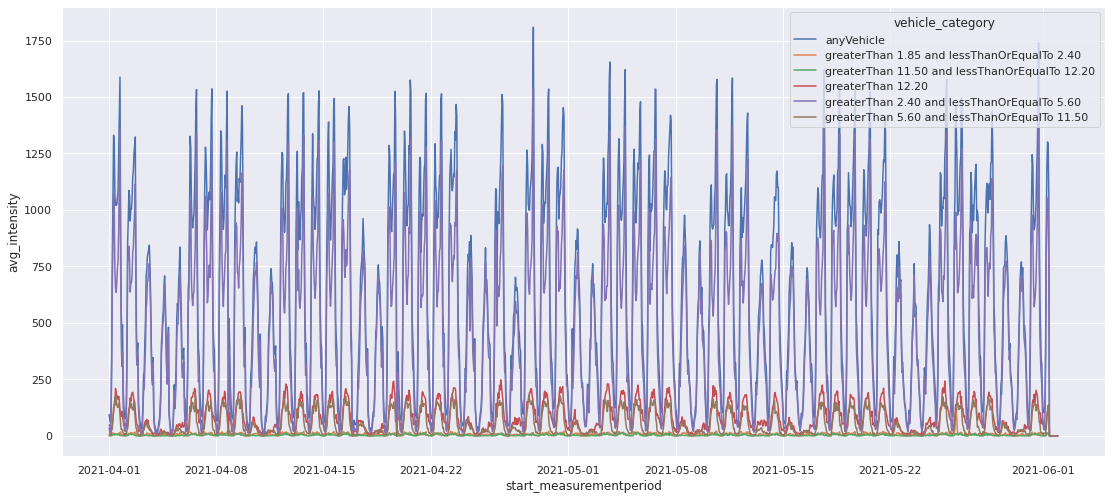

In [8]:
#Plot hourly number of vehicles on this measurement lcoation by vehiclecategory
sns.lineplot(x="start_measurementperiod", y="avg_intensity",hue='vehicle_category', data=by_category.reset_index())

In [9]:
#Select unique sensors based on sensorlocation id, to establish list of unique sensors.
locations = df.drop_duplicates(['id_sensorlocation'])[['id_sensorlocation','location_name','location_name_mst','start_location_latitude','start_location_longitude','number_of_traffic_lanes']]
locations.head()
locations.to_csv('locations.csv',index=False)

In [10]:
df.lane_type.unique()

array(['mainCarriageway'], dtype=object)

In [11]:
#!pip install -q ipyleaflet

In [12]:
#from ipyleaflet import Map, Marker, MarkerCluster

m = Map(center=(52.2984, 5.0125), zoom=8)

def get_callback(marker, location):
    def callback(*args, **kwargs):
        print (f"Selected sensor {marker.sensor_id} {marker.sensor_name}")
        #sensor_df = df[df.id_sensorlocation == marker.sensor_id].set_index(['start_measurementperiod','traffic_lane','vehicle_category'])
        #by_category = sensor_df.groupby(['start_measurementperiod','vehicle_category'])['avg_intensity'].sum()
        #sns.lineplot(x="start_measurementperiod", y="avg_intensity",hue='vehicle_category', data=by_category.reset_index())
    return callback

markers = []
sel_locations = locations
for i, row in sel_locations.iterrows():
    loc_marker = Marker(title=row.id_sensorlocation, location=(row.start_location_latitude, row.start_location_longitude))
    loc_marker.sensor_id = row.id_sensorlocation
    loc_marker.sensor_name = row.location_name
    loc_marker.on_click(get_callback(loc_marker, row))
    markers.append(loc_marker)
    
marker_cluster = MarkerCluster(markers=markers)



m.add_layer(marker_cluster);

m


Map(center=[52.2984, 5.0125], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

<AxesSubplot:xlabel='start_measurementperiod', ylabel='avg_intensity'>

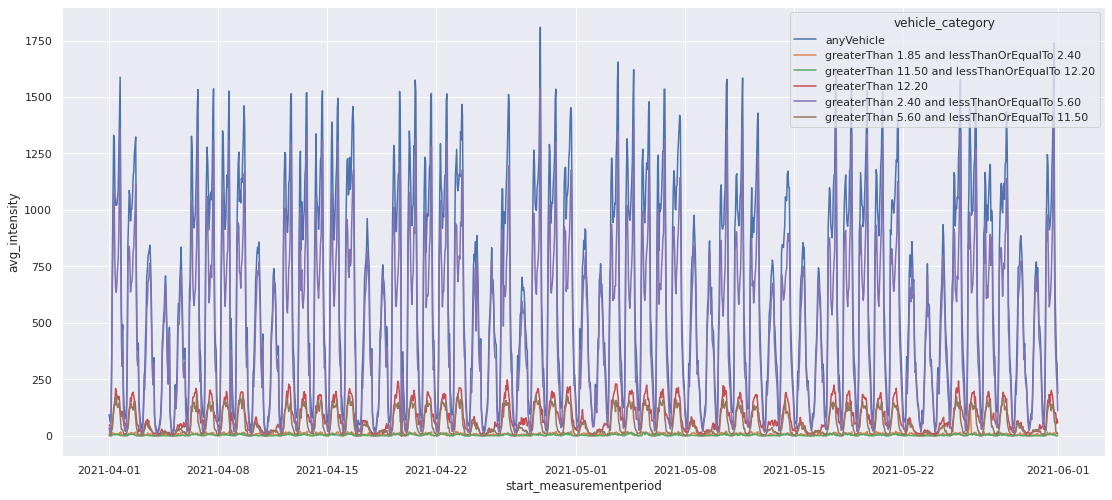

In [13]:
#Select sensor on 1 sensor
sensor_df = df[(df.id_sensorlocation == 'PNH02_TI854R') & (df.start_measurementperiod < '2021-06-01')]
by_category = sensor_df.groupby(['start_measurementperiod','vehicle_category'])['avg_intensity'].sum()
sns.lineplot(x="start_measurementperiod", y="avg_intensity",hue='vehicle_category', data=by_category.reset_index())

<AxesSubplot:xlabel='start_measurementperiod', ylabel='avg_intensity'>

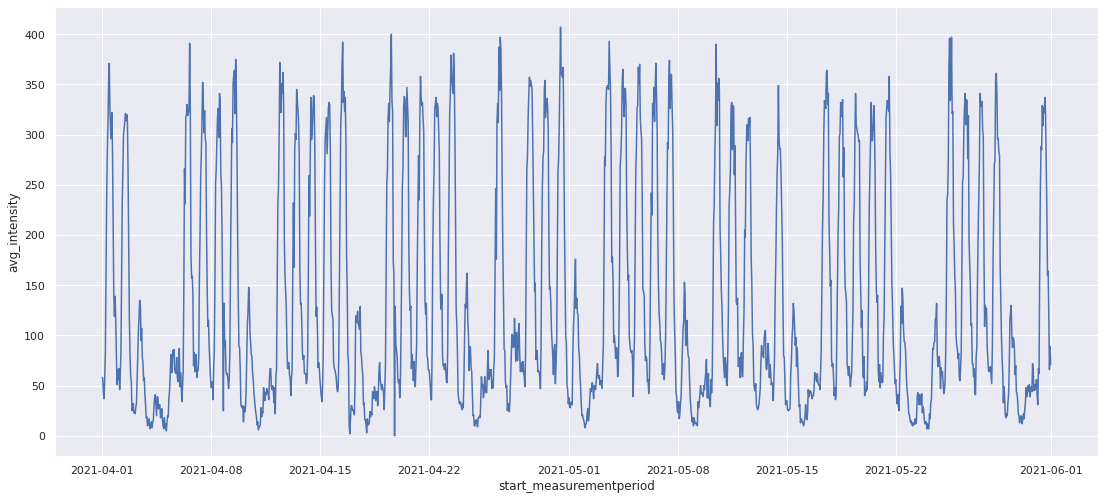

In [14]:
#Only select freight traffic for this sensor, plot this per day
sensor_freight_df = sensor_df[sensor_df.vehicle_category.isin(['greaterThan 5.60 and lessThanOrEqualTo 12.20','greaterThan 11.50 and lessThanOrEqualTo 12.20','greaterThan 5.60 and lessThanOrEqualTo 11.50','greaterThan 12.20'])]
freight_per_hour = sensor_freight_df.groupby(['start_measurementperiod'])['avg_intensity'].sum().to_frame()
sns.lineplot(x="start_measurementperiod", y="avg_intensity", data=freight_per_hour.reset_index())

In [15]:
#List all unique vehicle categories in this data for the selected sensor.
sensor_df.vehicle_category.unique()

array(['greaterThan 1.85 and lessThanOrEqualTo 2.40',
       'greaterThan 2.40 and lessThanOrEqualTo 5.60',
       'greaterThan 5.60 and lessThanOrEqualTo 11.50',
       'greaterThan 11.50 and lessThanOrEqualTo 12.20',
       'greaterThan 12.20', 'anyVehicle'], dtype=object)

Text(0.5, 1.0, 'ACF original')

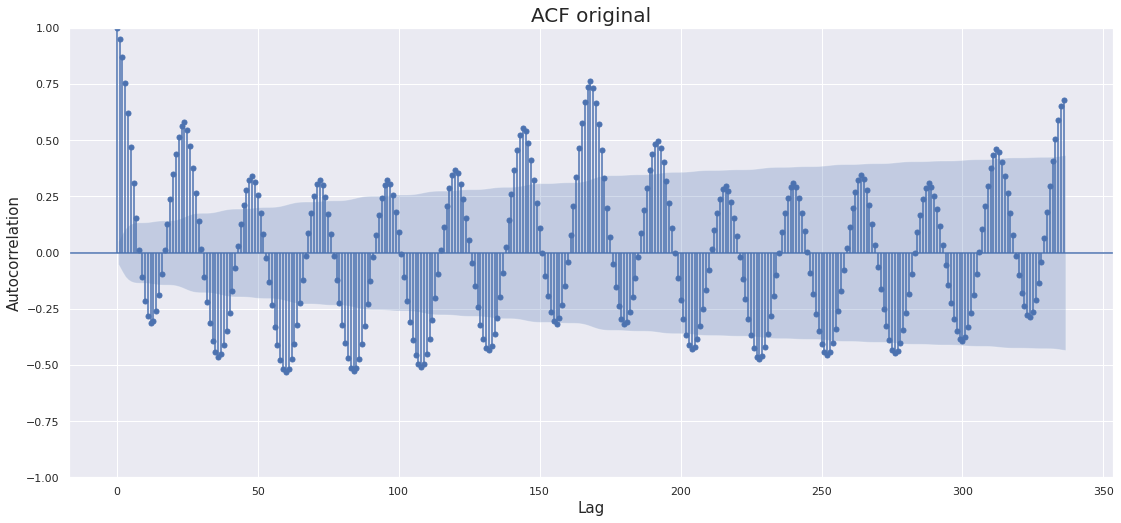

In [16]:
statsmodels.graphics.tsaplots.plot_acf(freight_per_hour, lags=2*168)
plt.xlabel("Lag", fontsize=15)
plt.ylabel("Autocorrelation", fontsize=15)
plt.title("ACF original", fontsize=20)

From the ACF plot we can note the following:
- From the high peaks at every 168 hours, it can be determined that the time series is correclated with a ∆t = 1 week shifted variance of itself. Hence, we can observe a weekly seasonality in the dataset.

In the following section, we will look at ways to address the issues of noisy and missing observations by aggregating the data.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF original')

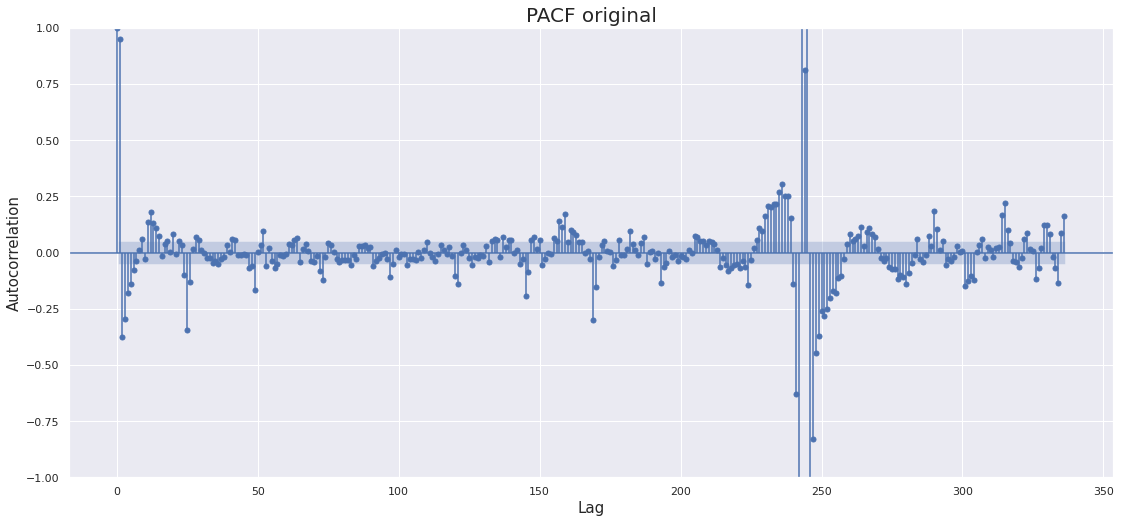

In [17]:
statsmodels.graphics.tsaplots.plot_pacf(freight_per_hour, lags=2*168)
plt.xlabel("Lag", fontsize=15)
plt.ylabel("Autocorrelation", fontsize=15)
plt.title("PACF original", fontsize=20)

# Time series modeling 

Next, we create a benchmark model. If your model predicts worse than this benchmark model, it indicates that your model might not be fit for the problem at hand. Since we can see a clear weekly seasonality, we choose a weekly seaonal naive model as a benchmark model. This model predicts the value of the current time based on the value of the previous week.

To compare the model we need the following:

A key performance indicater (KPI), i.e. a metric for comparing the models
A part of the dataset for testing purposes. This is necessary because we need to know how our models handels new data. If you test on existing data you run the risk of overfitting on your data.
The KPI chosen is the commonly used Root Mean Square Error (RMSE). The RMSE squares the errors. This way, predictions that are further away from the real value get penalized quadratically more compared to less extreme error values.

For the second item we split the dataset in three parts: a training, validation and test set.

The training set is used to train the model
The validation set is used to tune the parameters of the model
The test set is to compare the best parameters of each model. This way every step has a fresh new dataset to evaluate on, that prevents overfitting. A split chosen is 80/10/10. First, let us look at the size of the dataset.


In [18]:
print(len(freight_per_hour))

1464


We can see that the validation and test set should thus be around 146.4 data points. Since we have weekly seasonality it is preferable to use full weeks for the validation and test set. Otherwise, some parts of the week have a higher weight when selecting the model.

We therefore choose two weeks or 336 datapoints as our training and test set. A seasonal naive model has no parameters and requires no training, so the RMSE can immediately be calculated on the test set using the value one week (168 points) before.

In [19]:
test_size = 168 #Single week: 7 days, 7 * 24 hours.
test_split_second = len(freight_per_hour) - test_size
test_split_first = test_split_second - test_size
train_set = freight_per_hour.iloc[0:test_split_first]
test_set_first = freight_per_hour.iloc[test_split_first:test_split_second]
test_set_second = freight_per_hour.iloc[test_split_second:]

### Root Mean Squared Error

The MSE does not exhibit a proper unit of measurement - in our example the error would be demand squared. It is therefore common practice to take the square root of the MSE, which is equivalent to calculating the Euclidean distance between model and data. This root mean squared error (RMSE) effectively has the same unit of measurement as the data.

In [20]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Mean Absolute Percentage Error

Yet another popular and also unitless error metric is the mean absolute percentage error (MAPE), which measures the absolute deviation of prediction from observations in percent, 
$$\text{MAPE}=\frac{1}{n} \sum_{t=1}^n  \frac{|\hat y_{t}-y_{t}|}{|y_{t}|}.$$

In [21]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [22]:
real_values_sn = freight_per_hour.tail(336)
pred_values_sn = freight_per_hour.shift(168).tail(336)
rmse_sn = rmse(pred_values_sn, real_values_sn)
print(f"RMSE {rmse_sn}")

mape_sn = mape(pred_values_sn, real_values_sn)
print(f"MAPE {mape_sn}")

RMSE avg_intensity    71.744773
dtype: float64
MAPE 54.05769879803651


This value itself does not mean too much on its own, but will be compared with more complex models.

Text(0.5, 1.0, 'Visualisation of seasonal naive for sensor-location PNH02_TI854R')

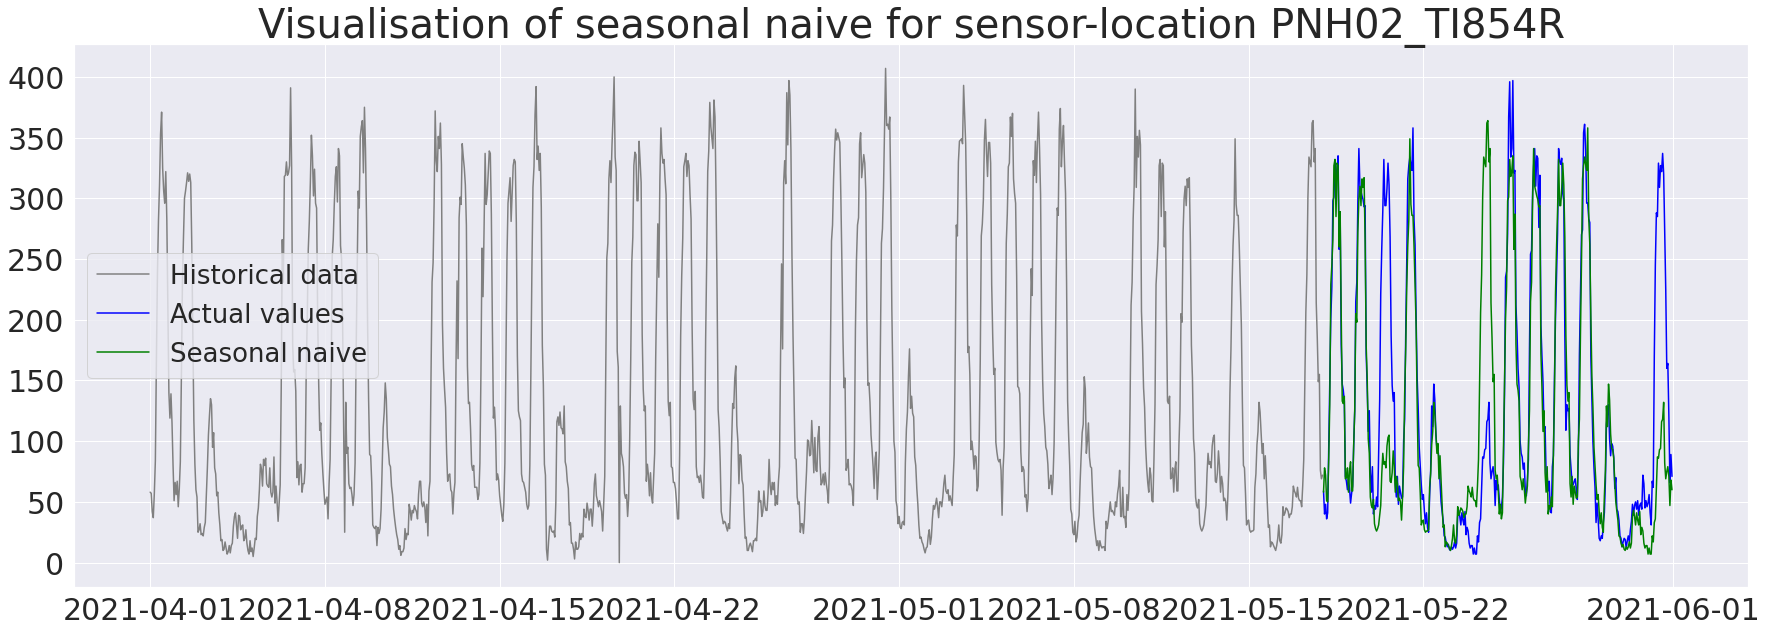

In [23]:
plt.figure(figsize=(30,10))

plt.plot(train_set,c='gray')
plt.plot(test_set_first.append(test_set_second), c='blue')
plt.plot(freight_per_hour.shift(168).tail(336), c='green')
plt.legend(['Historical data', 'Actual values', 'Seasonal naive'], prop={'size': 26})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.title(f'Visualisation of seasonal naive for sensor-location {sensor_df.id_sensorlocation.unique()[0]}',fontsize=40)

In [24]:
freight_per_hour

,avg_intensity
start_measurementperiod,
2021-04-01 00:00:00,58.0
2021-04-01 01:00:00,57.0
2021-04-01 02:00:00,42.0
2021-04-01 03:00:00,37.0
2021-04-01 04:00:00,57.0
...,...
2021-05-31 19:00:00,164.0
2021-05-31 20:00:00,121.0
2021-05-31 21:00:00,66.0


# Long Short Term Memory (LSTM)

In [25]:
#!pip install -q tensorflow

In [26]:
#import tensorflow as tf
#from tensorflow import keras

In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    ts = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        ts.append(X.iloc[i + time_steps].name)
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys), ts

In [28]:
time_steps = 24

X_train, y_train, ts_train = create_dataset(train_set, train_set.avg_intensity, time_steps)
X_test, y_test, ts_test = create_dataset(test_set_first.append(test_set_second), test_set_first.append(test_set_second).avg_intensity, time_steps)

print(X_train.shape, y_train.shape)


(1104, 24, 1) (1104,)


In [29]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)


In [30]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)


Epoch 1/100
63/63 [==============================] - 6s 36ms/step - loss: 31448.5664 - val_loss: 18197.5254
Epoch 2/100
63/63 [==============================] - 1s 20ms/step - loss: 28183.6602 - val_loss: 16230.6846
Epoch 3/100
63/63 [==============================] - 1s 20ms/step - loss: 26057.3281 - val_loss: 15041.2129
Epoch 4/100
63/63 [==============================] - 1s 21ms/step - loss: 24611.3789 - val_loss: 14148.4561
Epoch 5/100
63/63 [==============================] - 1s 21ms/step - loss: 23409.0293 - val_loss: 13363.3818
Epoch 6/100
63/63 [==============================] - 1s 20ms/step - loss: 22318.0020 - val_loss: 12658.5615
Epoch 7/100
63/63 [==============================] - 2s 27ms/step - loss: 21315.6230 - val_loss: 12016.9980
Epoch 8/100
63/63 [==============================] - 2s 30ms/step - loss: 20388.6758 - val_loss: 11426.0654
Epoch 9/100
63/63 [==============================] - 1s 20ms/step - loss: 19499.3086 - val_loss: 10868.0449
Epoch 10/100
63/63 [========

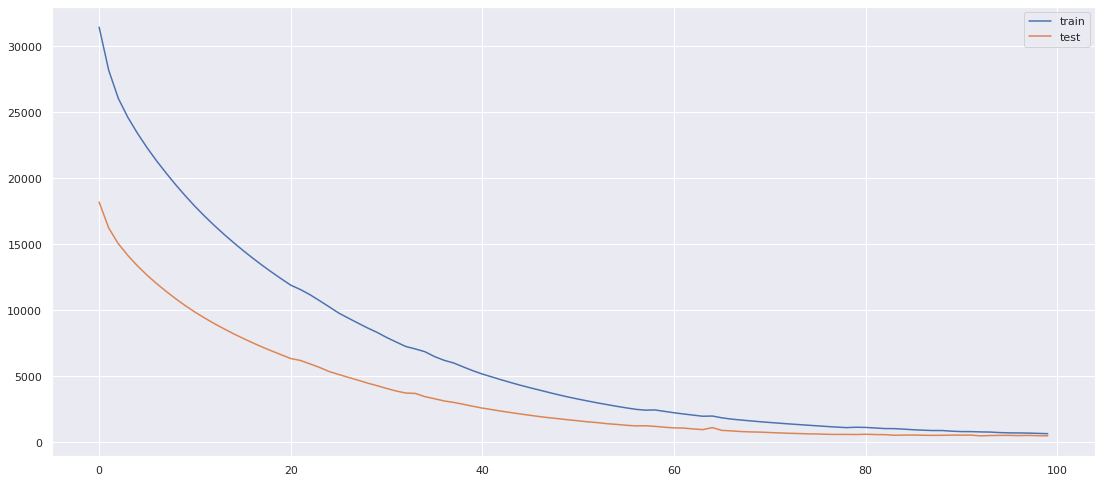

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [32]:
y_pred = model.predict(X_test)

10/10 [==============================] - 1s 11ms/step


Text(0.5, 1.0, 'Visualisation of LSTM for sensor-location PNH02_TI854R')

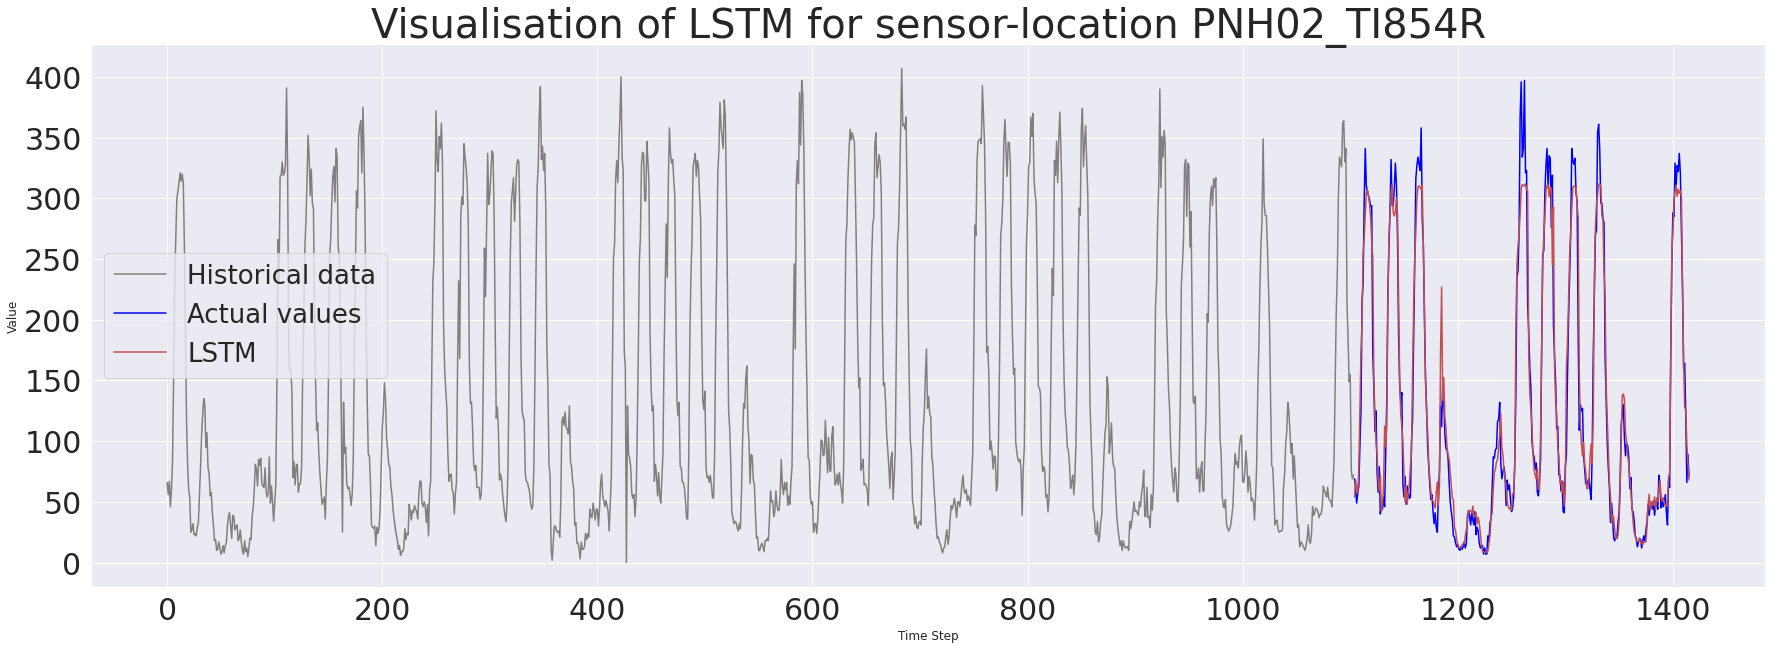

In [33]:
plt.figure(figsize=(30,10))

plt.plot(np.arange(0, len(y_train)), y_train, 'gray', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, 'blue', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend(['Historical data', 'Actual values', 'LSTM'], prop={'size': 26})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.title(f'Visualisation of LSTM for sensor-location {sensor_df.id_sensorlocation.unique()[0]}',fontsize=40)

In [34]:
df_lstm_test = pd.DataFrame(data=y_test, index=ts_test, columns=["avg_intensity"]).rename_axis('start_measurementperiod')
df_lstm_pred = pd.DataFrame(data=y_pred, index=ts_test, columns=["avg_intensity"]).rename_axis('start_measurementperiod')
df_lstm_test.head()

,avg_intensity
start_measurementperiod,
2021-05-19 00:00:00,69.0
2021-05-19 01:00:00,61.0
2021-05-19 02:00:00,49.0
2021-05-19 03:00:00,57.0
2021-05-19 04:00:00,63.0


In [35]:
real_values_sn = freight_per_hour.tail(len(y_pred))
pred_values_sn = freight_per_hour.shift(168).tail(len(y_pred))
rmse_sn = rmse(pred_values_sn.avg_intensity, real_values_sn.avg_intensity)
print(f"Seasonal naive RMSE {float(rmse_sn)}")

mape_sn = mape(pred_values_sn.avg_intensity, real_values_sn.avg_intensity)
print(f"Seasonal naive MAPE {mape_sn}")

Seasonal naive RMSE 74.27843062700138
Seasonal naive MAPE 57.32671291663078


In [36]:
rmse_lstm = rmse(df_lstm_test, df_lstm_pred)
print(f"RMSE LSTM {float(rmse_lstm)}")

mape_lstm = mape(df_lstm_test, df_lstm_pred)
print(f"MAPE LSTM {mape_lstm}")

RMSE LSTM 24.56375907357746
MAPE LSTM 19.687446712023775


As this LSTM model produces a lower RSME and MAPE, it already performs better than the seasonal naive model. However there are still plenty of venues to improve the parameters of this model, as no effort was put into tuning this far.

Text(0.5, 1.0, 'Visualisation for sensor-location PNH02_TI854R')

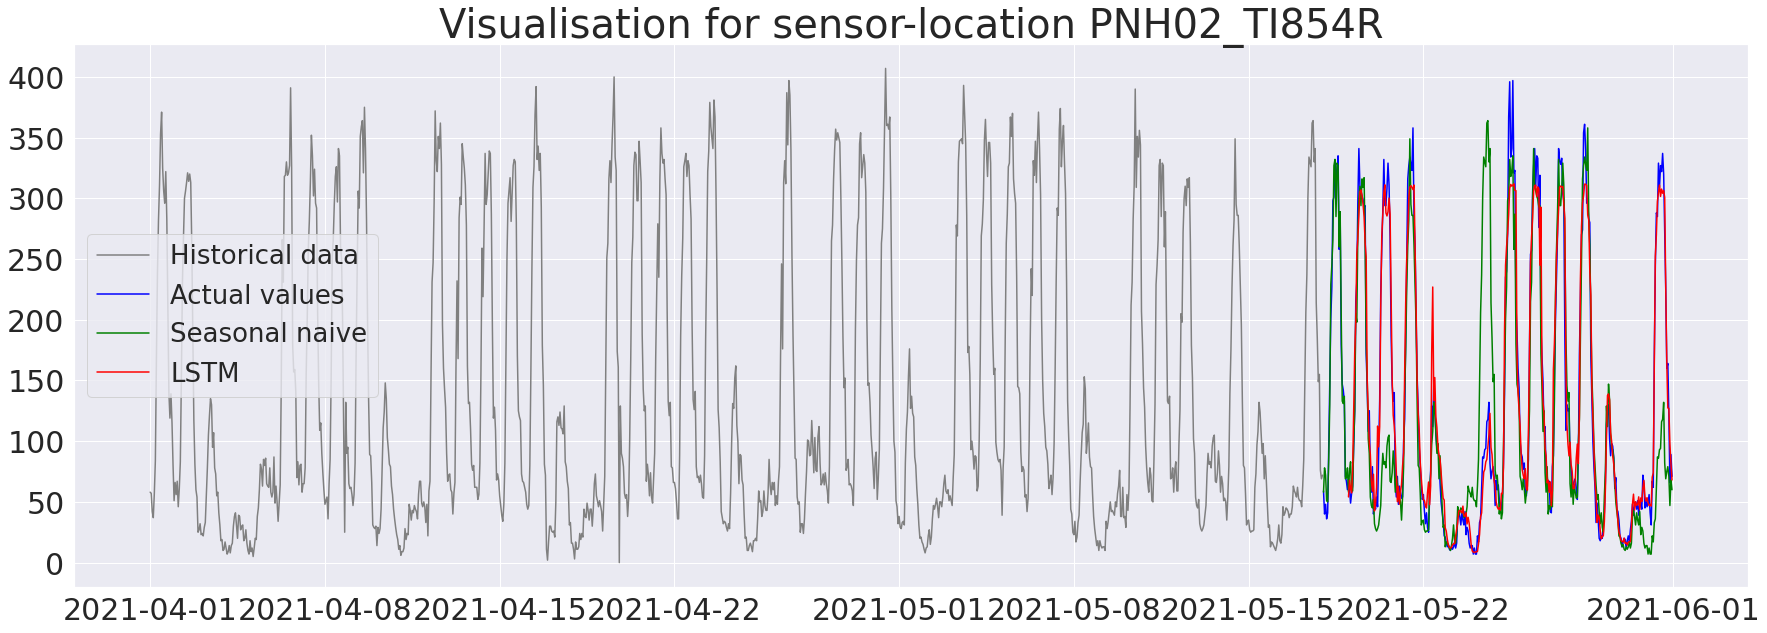

In [37]:
plt.figure(figsize=(30,10))

plt.plot(train_set,c='gray')
plt.plot(test_set_first.append(test_set_second), c='blue')
plt.plot(freight_per_hour.shift(168).tail(336), c='green')
plt.plot(df_lstm_pred, c='red')

plt.legend(['Historical data', 'Actual values', 'Seasonal naive','LSTM'], prop={'size': 26})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.title(f'Visualisation for sensor-location {sensor_df.id_sensorlocation.unique()[0]}',fontsize=40)

Text(0.5, 1.0, 'Visualisation for sensor-location PNH02_TI854R')

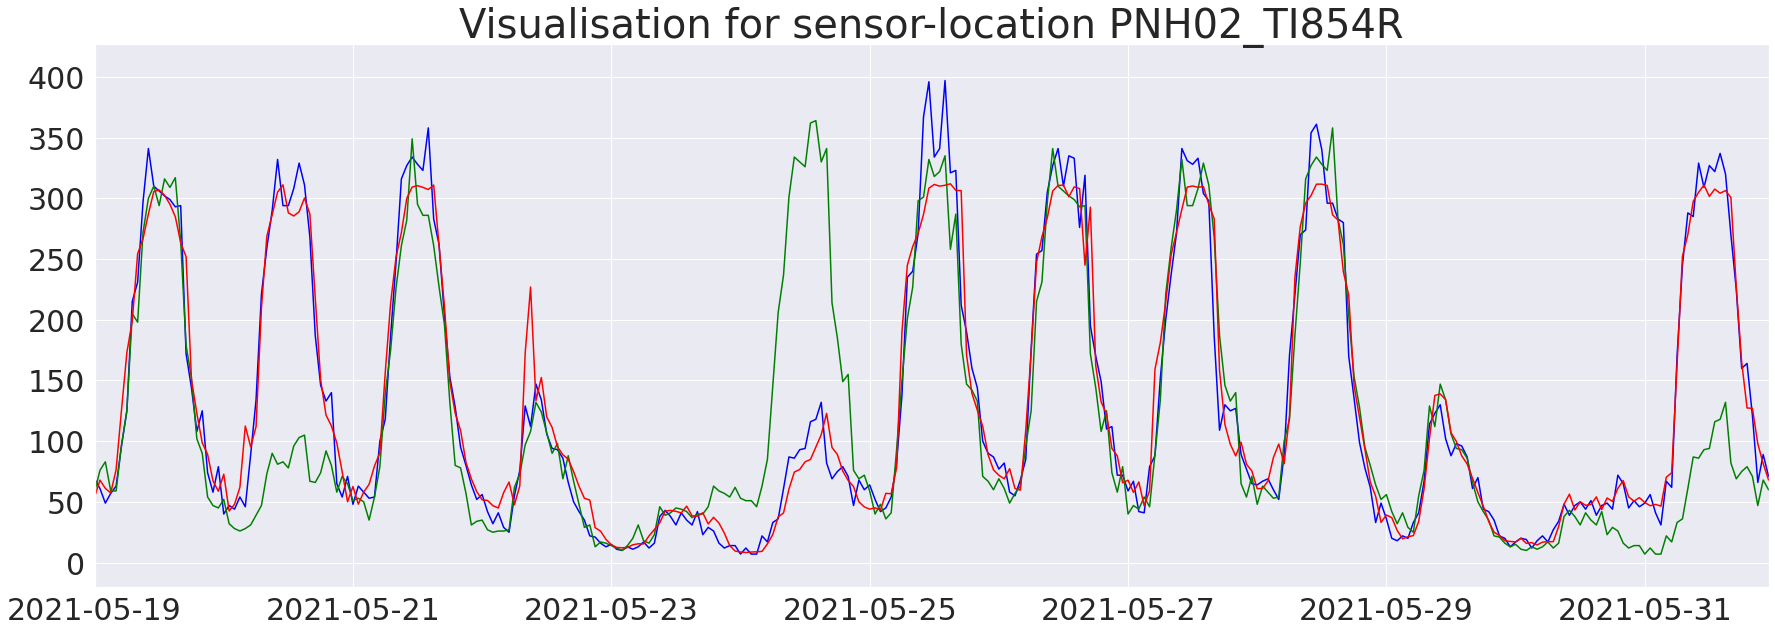

In [38]:
plt.figure(figsize=(30,10))

plt.plot(train_set,c='0.2')
plt.plot(test_set_first.append(test_set_second), c='blue')
plt.plot(freight_per_hour.shift(168).tail(336), c='green')
plt.plot(df_lstm_pred, c='red')

#plt.legend(['Historical data', 'Real values', 'Seasonal naive','LSTM'], prop={'size': 26})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.xlim([ts_test[0], ts_test[-1]])
plt.title(f'Visualisation for sensor-location {sensor_df.id_sensorlocation.unique()[0]}',fontsize=40)

In [39]:
len(locations)

1

# Extreme Gradient Boost (XGBoost)

In [40]:
#import xgboost as xgb
#from xgboost import plot_importance, plot_tree

In [41]:
def create_features(df, label=None,extra_features=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    cols = ['hour','dayofweek','quarter','month','year','dayofmonth','weekofyear']
    #Include extra columns from dataframe if given
    if extra_features is not None:
        cols += extra_features
    X = df[cols]
    if label:
        y = df[label]
        return X, y
    return X

In [42]:
tsdf = freight_per_hour.copy().reset_index()
#Add moving averages as features.
tsdf['SMA_14'] = tsdf.iloc[:,1].rolling(window=14).mean()
tsdf['SMA_7'] = tsdf.iloc[:,1].rolling(window=7).mean()
tsdf['SMA_28'] = tsdf.iloc[:,1].rolling(window=28).mean()

train = tsdf.iloc[:-test_size].set_index('start_measurementperiod')
test = tsdf.iloc[-test_size:].set_index('start_measurementperiod')

extra_features = ['SMA_14','SMA_7']
X_train, y_train = create_features(train, label='avg_intensity',extra_features=extra_features)
X_test, y_test = create_features(test, label='avg_intensity',extra_features=extra_features)

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=True) # Change verbose to True if you want to see it train


[0]	validation_0-rmse:124.50172	validation_1-rmse:129.02712
[1]	validation_0-rmse:88.64739	validation_1-rmse:91.73468
[2]	validation_0-rmse:63.54869	validation_1-rmse:65.69225
[3]	validation_0-rmse:46.14644	validation_1-rmse:49.18363
[4]	validation_0-rmse:34.09595	validation_1-rmse:36.32141
[5]	validation_0-rmse:25.81907	validation_1-rmse:28.72513
[6]	validation_0-rmse:20.33532	validation_1-rmse:23.95549
[7]	validation_0-rmse:16.74458	validation_1-rmse:21.06879
[8]	validation_0-rmse:14.23354	validation_1-rmse:20.10547
[9]	validation_0-rmse:12.48598	validation_1-rmse:19.34449
[10]	validation_0-rmse:11.28764	validation_1-rmse:19.05851
[11]	validation_0-rmse:10.50760	validation_1-rmse:19.08105
[12]	validation_0-rmse:9.99655	validation_1-rmse:18.99628
[13]	validation_0-rmse:9.66119	validation_1-rmse:19.00812
[14]	validation_0-rmse:9.37183	validation_1-rmse:18.96769
[15]	validation_0-rmse:9.07256	validation_1-rmse:18.74197
[16]	validation_0-rmse:8.87986	validation_1-rmse:18.87460
[17]	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

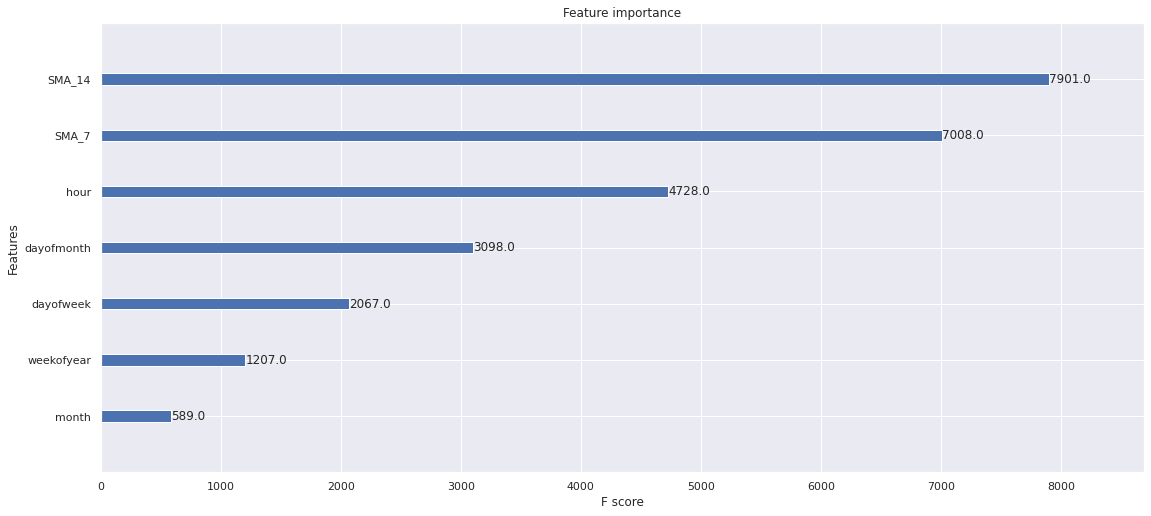

In [43]:
_ = plot_importance(reg)

Text(0.5, 1.0, 'Visualisation of XGB for sensor-location PNH02_TI854R')

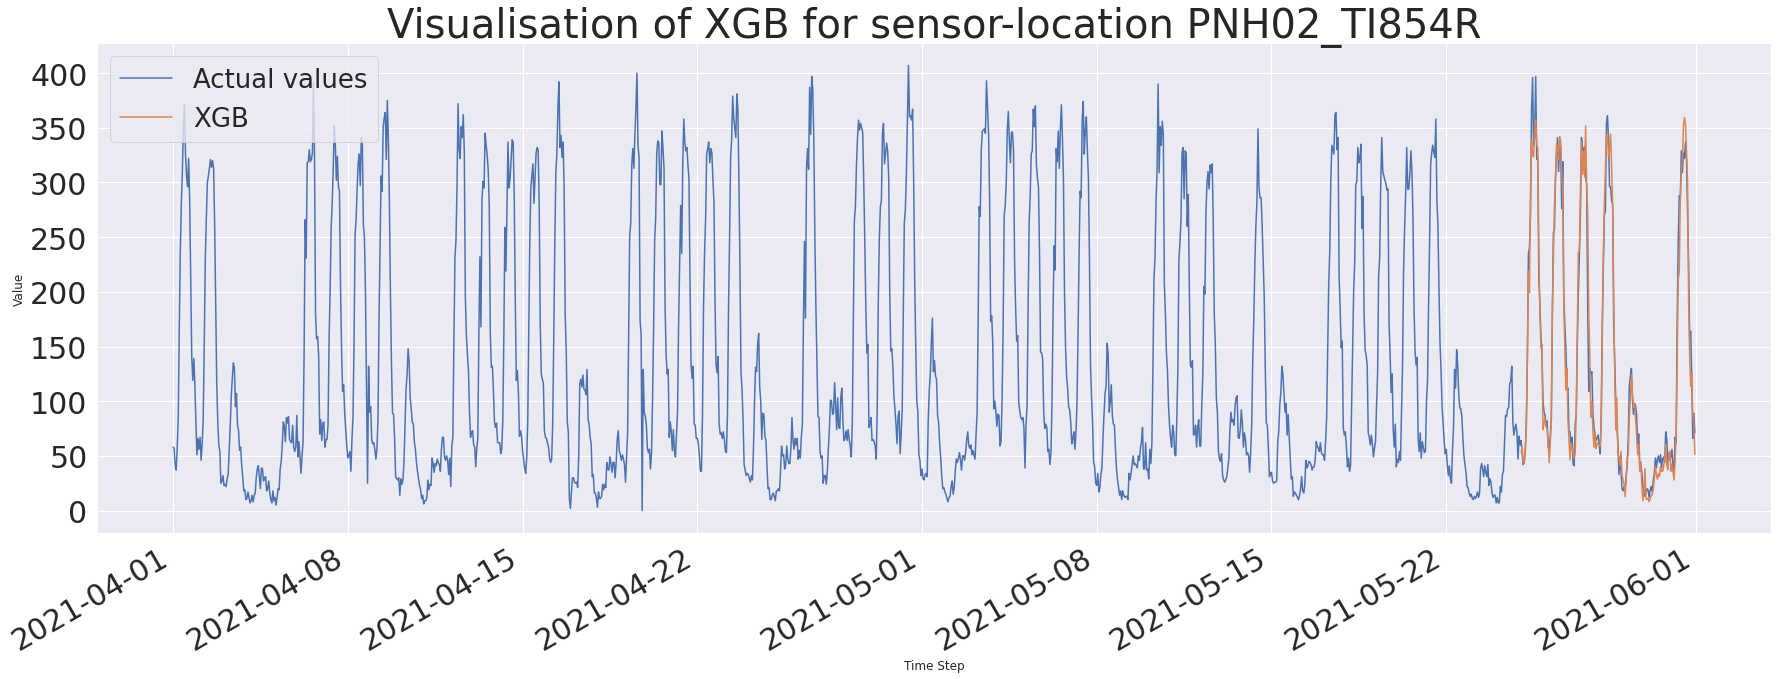

In [44]:
test['Intensity_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['avg_intensity','Intensity_Prediction']].plot(figsize=(30, 10))

plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend(['Actual values', 'XGB'], prop={'size': 26})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.title(f'Visualisation of XGB for sensor-location {sensor_df.id_sensorlocation.unique()[0]}',fontsize=40)

In [45]:
real_values_xgb = test['avg_intensity'].tail(test_size)
pred_values_xgb = test['Intensity_Prediction'].tail(test_size)
rmse_xgb = rmse(real_values_xgb, pred_values_xgb)
print(f"RMSE {rmse_xgb}")
mape_xgb = mape(real_values_xgb, pred_values_xgb)
print(f"MAPE {mape_xgb}")

RMSE 21.020927782168318
MAPE 16.724224629610323


The XGBoost model performs better than the untuned LSTM mdoel.

# Exercise

Can you repeat the analysis for a different sensor?